# Učitavanje biblioteka za rad 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import shuffle
import seaborn as sb
import pickle

font = {'size'   : 15}

matplotlib.rc('font', **font)

random.seed(1)

# Učitavanje podataka 

In [3]:
def get_classes_info(y: np.ndarray, show_text: bool=True) -> list:
    
    """
        Funkcija za izvlacenje klasa i prebrojavanja primera
        sa istom klasom
        
        params: 
            - y: vektor klasa
                               
        :return:
            - classes: lista klasa
            - classes_dict: recnik klasa sa njihovim brojem predstavnika
    """
    # dohvatanje svih vrednosti klasa
    classes = []
    for _class in y:
        if _class not in classes:
            classes.append(int(_class))
    classes.sort()
            
    # prebrojavanje predstavnika klasa
    classes_dict = dict.fromkeys(classes)
    for _class in classes:
        class_count = np.count_nonzero(y == _class)
        classes_dict[_class] = class_count
        
    # broj klasa
    k = len(classes_dict.keys())
        
    # ispis podataka o klasama u dataset-u
    if show_text:
        print('-------------------------------------------------------')
        print(f'Ukupan broj klasa kojima pripadaju ucitani primeri je: {k}\n')
        print('Ucitane klase i brojevi njhovih predstavnika/primera su: ')
        for _class in classes_dict.keys():
            print(f'\tKlasa {_class}: {classes_dict[_class]} primera')
        print('-------------------------------------------------------')
    
    return classes, classes_dict

In [4]:
data = pd.read_csv('multiclass_data.csv').to_numpy()
X, y = data[:,0:5], data[:,5]

print('-------------------Ucitani su podaci-------------------')
print(f'Ukupan broj ucitanih primera je: {X.shape[0]}')
print(f'Ukupan broj ucitanih prediktora (dim(X)) je: {X.shape[1]}')

classes, _ = get_classes_info(y)

-------------------Ucitani su podaci-------------------
Ukupan broj ucitanih primera je: 177
Ukupan broj ucitanih prediktora (dim(X)) je: 5
-------------------------------------------------------
Ukupan broj klasa kojima pripadaju ucitani primeri je: 3

Ucitane klase i brojevi njhovih predstavnika/primera su: 
	Klasa 0: 58 primera
	Klasa 1: 71 primera
	Klasa 2: 48 primera
-------------------------------------------------------


Klase nisu "savršeno balansirane" (pojednaka brojčane), medjutim ne može se reći ni da su nebalansirane, s obzirom na to da broj primera svake pojedinačne klase nije drastično mali, npr. klasa 2 ima 3 odbirka. \
Ovaj problem nebalansiranih klasa moguće "rešiti", tj. unekoliko poboljšati vršenjem takozvanog *oversampling*-a, ne bi li se broj primera najnemnogobrojnije klase iole mogao izjednačiti sa ostalim klasama, ili otežinjavanjem primera najnemnogobrojnije klase prilikom računanje funkcije gubitka. \
*Oversampling* podrazumeva da se pomoću estimirane raspodele podataka najnemnogobrojnije klase, generišu neki novi podaci koji navodno pripadaju toj klasi (često se za ovaj postupak upotrebljava k-Nearest-Neighbours algoritam). 

# --------------------------------- Softmax logistička klasifikacija ---------------------------------

# Teorijski osvrt

Logistička regresija je algoritam za binarnu klasifikaciju. Ne može se primeniti direktno u slučajevima kada postoji više od dve ciljne klase. Jedna mogućnost je tzv "jedan-protiv-ostalih" strategija: za svaku klasu projektuje se po jedan binarni klasifikator, koji odlučuje da li primer pripada toj klasi ili ne. Druga mogućnost je "jedan-protiv-jednog", gde projektujemo po jedan klasifikator za svaki par klasa.


**Multinomijalna logistička regresija**, poznatija pod nazivom **Softmax** klasifikator, prirodno podržava probleme sa više od 2 ciljne klase. U pitanju je generalizovani linearni model koji izlaznoj promenljivoj $y$ pridružuje multinomijalnu raspodelu:
$$
\Pr(Y=i) = \phi_i, \quad i=1, \ldots, k
\\
\sum_{i=1}^k \phi_i = 1
$$

# Implementacija potrebnih funkcija

In [5]:
def read_data(path: str='multiclass_data.csv', separator_index: int=5) -> tuple:
    
    """
        Funkcija za ucitavanje podataka na osnovu kojih se
        kreira model.
        
        :params: 
            - path: putanja do .csv fajla sa podacima
            - separator_index: broj kolone do koje se nalaze
                               ulazni podaci, odnosno od koje
                               pocinju izlazni podaci
                               
        :return:
            - X: matrica primera svih prediktora
            - y: vektor izlaza
    """
    
    data = pd.read_csv(path).to_numpy()
    
    # razdvajanje ulaznih i izlaznih promenljivih
    X, y = data[:,0:separator_index], data[:,separator_index]
    
    return X, y

In [6]:
def train_test_data_split(X: np.ndarray, y: np.ndarray, split_ratio: float=0.8) -> tuple:
    
    """
        Funkcija za mesanje klasa i splitovanje svih dostupnih podataka na 
        trening/obucavajuce i test podatke prema zadatom postotku (split_ratio).
        U funkciji se vodi racuna da balans izmedju klasa u dva nova skupa podataka
        bude isti kao i kod originalnih prosledjenih podataka.
        
        :params:
            - X: matrica primera svih prediktora
            - y: vektor klasa 
            - split_ratio: vrednost iz intervala [0,1] koja oznacava procenat
                           trening podataka
                           
        :return:
            - X_train: matrica primera svih prediktora za trening skup
            - y_train: vektor izlaza za trening skup
            - X_test: matrica primera svih prediktora za test skup
            - y_test: vektro izlaza za test skup
    """
    
    random.seed(1)
    
    # broj primera trening skupa
    m_train = 0
    
    classes, classes_dict = get_classes_info(y, False)
    
    train_indices = set()
    test_indices = set()
    
    # formiranje zasebnih splitova, kako bi svaka klasa imala split_ratio * 100% odbiraka u trening skupu
    for i in classes:
        m = classes_dict[i]
        
        class_train_set_size = int(m*split_ratio)
        m_train += class_train_set_size

        class_ind = np.where(y == i)[0].tolist()

        # odredjivanje indeksa za trening skup za jednu klasu
        class_train_set_ind = random.sample(class_ind, k=class_train_set_size)
        
        # dodavanje u globalni set indeksa za trening skup
        train_indices.update(list(class_train_set_ind))

        # odredjivanje indeksa za test skup za jednu klasu
        class_test_set_ind = set(class_ind) - set(class_train_set_ind)
        
        # dodavanje u globalni set indeksa za test skup
        test_indices.update(list(class_test_set_ind))
        
    train_indices = list(train_indices)
    test_indices = list(test_indices)
    
    # podela podataka na trening i test podatke
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    
    # mesanje podataka
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    X_test, y_test = shuffle(X_test, y_test, random_state=0)
    
    return X_train, y_train, X_test, y_test

# Implementacija funkcija za Softmax model

In [7]:
def expand_predictors(X: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za prosirivanje matrice prediktora kolonom jedinica.
        
        :params:
            - X: matrica primera svih prediktora
            
        :return:
            - X: prosirena matrica primera svih prediktora
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # prosirivanje prediktora sa kolonom jedinica ispred
    X_expand = np.concatenate((np.ones((m,1)), X), axis=1)
    return X_expand

In [8]:
def get_batches(X_train: np.ndarray, y_train: np.ndarray, batch_size: int) -> list:
    
    """
        Funkcija za dohvatanje liste svih batch-eva / sarzi iz trening skupa.
        
        :params:
            - X_train: matrica primera svih prediktora trening skupa
            - y_train: vektor klasa trening skupa
            - batch_size: velicina sarze
                           
        :return:
            - batches: lista sa podeljenim trening skupom u tuple objekte
    """
    
    # dohvatanje broja primera u trening skupu
    m = X_train.shape[0]
    
    # broj mini-batch-eva, tj. sarzi
    if batch_size >= m:
        num_batches = 1
        batch_size = m
    else:
        num_batches = int(m/batch_size)
    
    batches = []
    
    for i in range(num_batches):
        start_ind = i*batch_size
        end_ind = (i+1)*batch_size if i != num_batches-1 else m
        
        batches.append((X_train[start_ind:end_ind, :], y_train[start_ind:end_ind]))
        
    return batches

In [9]:
def get_statistics(X: np.ndarray) -> tuple:
    
    """
        Funkcija za dohvatanje statistika - srednja vrednost i standardna devijacija. 
        Za svaka od kolona matrice X vrsi se izracunavanje statistika, s obzirom na to da
        one predstavljaju posebne prediktore.
        
        :params:
            - X: matrica primera svih prediktora
            
        :return:
            - mu: vektor srednjih vrednosti za svaki prediktor
            - std: vektor standardnih devijacija za svaki prediktor
    """
    
    # broj prediktora
    n = X.shape[1]
    
    # vektor srednjih vrednosti za svaki prediktor ponaosob
    mu = np.zeros(n)
    
    # vektor standardnih devijacija za svaki prediktor ponaosob
    std = np.zeros(n)
    
    for i in range(n):
        mu[i] = np.mean(X[:,i])
        std[i] = np.std(X[:,i])
    
    return mu, std

In [10]:
def standardize(X: np.ndarray, mu: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    
    """
        Funkcija za standardizaciju prediktora - postavljanje prediktora na istu skalu.
        Svaka kolona matrice X se standardizuje sa sebi svojstvenim statistikama - mu i std,
        s obzirom na to da su to posebni prediktori i da u opstem slucaju ne moraju biti na istoj skali.
        
        :params:
            - X: matrica primera svih prediktora
            - mu: vektor srednjih vrednosti za svaki prediktor ili None
            - std: vektor standardnih devijacija za svaki prediktor ili None
            
        :return:
            - X: standardizovana matrica primera svih prediktora
    """
    
    # racunanje srednjih vrednosti i st. devijacije svih prediktora
    if mu is None and std is None:
        mu, std = np.mean(X, axis=0), np.std(X, axis=0)

    # standardizacija na normalnu raspodelu
    X = (X - mu) / std # ~ N(0,1)
    
    return X

In [11]:
def loss(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    
    """
        Funkcija za racunanje vrednosti funkcije gubitka modela,
        odnosno za racunanaje vrednosti log-verodostojnosti prilikom treniranja modela.
        
        :params:
            - X: prosirena matrica primera svih prediktora -> dimenzije m x (n+1)
            - y: vektor klasa -> dimenzije k x 1
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x (n+1)
            
        :return:
            - value: vrednost funkcije gubitka / log-verodostojnosti
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # dohvatanje broja klasa
    k = theta.shape[0]
    
    # indikatorska funkcija -> dim{I} = m x k
    I = np.array([y == j for j in range(k)]).T
    
    # racunanje vrednosti funkcije gubitka - log-verodostojnosti
    value = (np.sum((I @ theta)*X) - np.sum(np.log(np.sum(np.exp(theta @ X.T), axis=0))))/m
    
    return value

In [12]:
def gradients(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za racunanje vrednosti funkcije gubitka modela,
        odnosno za racunanaje vrednosti log-verodostojnosti prilikom treniranja modela.
        
        :params:
            - X: prosirena matrica primera svih prediktora -> dimenzije m x (n+1)
            - y: vektor klasa -> dimenzije k x 1
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x (n+1)
            
        :return:
            - grads: matrica gradijenata za svaku klasu -> dimenzije k x (n+1), kao matrica theta
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # dohvatanje broja klasa
    k = theta.shape[0]
    
    # indikatorska funkcija -> dim{I^T} = k x m
    I = np.array([y == j for j in range(k)])
    
    num = np.exp(theta @ X.T) 
    den = np.sum(np.exp(theta @ X.T), axis=0).reshape(1,-1)
    
    # racunanje gradijenata -> dim{grads} = k x (n+1)
    grads = (I - (num/den)) @ X
    
    return grads

In [13]:
def apply_gradients(theta: np.ndarray, grads: np.ndarray, lr: float) -> np.ndarray:
    
    """
        Funkcija za primenjivanje prethodno izracunatih gradijenata kriterijumske 
        funkcije po parameterima modela. Funkcija postavlja parametre poslednje klase na nule.
        
        :params:
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x (n+1)
            - grads: matrica gradijenata parametara modela za svaku klasu -> dimenzije k x (n+1)
            - lr: stopa obucavanja, parametar ponderisanja gradijenata
            
        :return:
            - theta_updated: azurirana matrica gradijenata za svaku klasu -> dimenzije k x (n+1)
    """

    # dohvatanje broja klasa
    k = theta.shape[0]
    
    theta_updated = np.zeros_like(theta)
    
    # primenjivanje gradijenta
    theta_updated[:-1,:] = theta[:-1,:] + lr*grads[:-1,:]
    
    return theta_updated

In [14]:
def train(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
          num_epochs: int, batch_size: int, lr: float, expand: bool=False, verbose: bool=True, show_results: bool=True) -> tuple:
    
    """
        Funkcija za treniranje softmax modela logisticke regresije, upotrebom numericke optimizacije,
        konkretno algoritma mini-sazrnog gradijentong uspona. Model se trenira maksimizacijom 
        verodostojnosti.
        
        :params:
            - X_train: [prosirena] matrica primera svih prediktora na trening skupu -> dimenzije m x n ili m x (n+1)
            - y_train: vektor klasa na trening skupu -> dimenzije k x 1
            - X_val: [prosirena] matrica primera svih prediktora na validacionom skupu -> dimenzije m x n ili m x (n+1)
            - y_val: vektor klasa na validacionom skupu -> dimenzije k x 1
            - num_epochs: broj epoha za treniranje
            - batch_size: velicina sarze
            - lr: stopa ucenja
            - expand: indikator za prosirivanje matrice prediktora jedinicama
            - verbose: indikator za ispis progresa
            - show_results: indikator za prikaz grafika treniranja
            
        :return:
            - best_theta: parametri koji daju najbolju vrednost kriterijumske funkcije prilikom treniranja
            - best_loss: vrednost kriterijumske funkcije u najboljem trenutku u treniranju
            - best_epoch: epoha u kojoj dolazi do optimalne vrednosti loss funkcije
    """
    
    #### DOHVATANJE SVIH DIMENZIJA ####
    
    # dohvatanje broja primera
    m = X_train.shape[0]
    
    # dohvatanje broja prediktora
    n = X_train.shape[1]
    
    # dohvatanja broja klasa
    k = len(get_classes_info(y_train, show_text=False)[0])
    
    #### PRIPREMA PODATAKA ####
    
    # dohvatanje sr. vrednosti i st. devijacije trening skupa
    mu, std = get_statistics(X_train)
    
    with open('statistics.pickle', 'wb') as file:
        pickle.dump((mu, std), file)

    # standardizacija trening skupa 
    X_train = standardize(X_train, mu, std)

    # standardizacija validacionog skupa sa statistikama iz trening skupa
    X_val = standardize(X_val, mu, std)
    
    if expand:
        # prosirivanje matrice prediktora kolonom jedinica na trening skupu
        X_train = expand_predictors(X_train) 

        # prosirivanje matrice prediktora kolonom jedinica na validacionom skupu
        X_val = expand_predictors(X_val) 

        # matrica parametara
        theta = np.zeros((k, n+1), dtype='float32')
        
    else:
        # matrica parametara
        theta = np.zeros((k, n), dtype='float32')
    
    #### INICIJALIZACIJA PRATECIH PROMENLJIVIH ####

    # promenljiva za cuvanje najbolje vrednosti kriterijumske funkcije
    best_loss = None
    best_theta = None
    best_epoch = None
    best_epoch_samples = None

    # liste za cuvanje vrednosti kriterijumske funkcije u toku obucavanja
    train_loss = []
    train_samples = []
    train_loss_epoch = []
    val_loss = []
    epoch_samples = []
    
    #### TRENIRANJE U PETLJI ####
    
    for epoch in range(1, num_epochs+1):
        
        # mesanje trening podataka na pocetku svake epizode
        X_train, y_train = shuffle(X_train, y_train, random_state=1)
        
        # dohvatanje sarzi
        batches = get_batches(X_train, y_train, batch_size)
        
        # resetovanje usrednjene epohalne funkcije gubitka
        train_loss_epoch_mean = 0
        
        # iteriranje po sarzama - treniranje parametera u okviru jedne epohe
        for i, batch in enumerate(batches):
            
            # razdvajanje ulaza od izlaza
            train_x, train_y = batch[0], batch[1]
            
            # racunanje funkcije gubitka - log-verodostojnosti
            loss_ = loss(train_x, train_y, theta)
            train_loss_epoch_mean += loss_
            train_loss.append(loss_)
            
            # racunanje gradijenta 
            grads = gradients(train_x, train_y, theta)
            
            # azuriranje parametara
            theta = apply_gradients(theta, grads, lr)
            
            # broj upotrebljenih primera
            train_samples.append(train_y.size + (train_samples[-1] if len(train_samples) else 0))
            
        # usrednjena epohalna funkcija gubitka na trening skupu
        train_loss_epoch.append(train_loss_epoch_mean/i)  
        
        # Broj primera u jednoj epohi
        epoch_samples.append(m + (epoch_samples[-1] if len(epoch_samples) else 0))
        
        # vrednost funkcije gubitka na validacionom skupu
        val_loss_ = loss(X_val, y_val, theta)
        val_loss.append(val_loss_)
            
        # cuvanje optimlanih parametara 
        if (best_loss is None) or (val_loss_ > best_loss):
            best_loss = val_loss_
            best_theta = theta
            best_epoch = epoch
            best_epoch_samples = epoch_samples[-1]
            
        # ispisavanje progresa treniranja
        if verbose:
            percentage = 100*epoch/(num_epochs+1)
            print('Izvrseno je {:.5}% procesa treniranja'.format(percentage), end='  \r')
            
    # iscrtavanja rezultata treniranja
    if show_results:
        fig = plt.figure(figsize=(14,10))
        plt.plot(train_samples, train_loss, color='tomato', label='trenirajuci skup - po iteracijama')
        plt.plot(epoch_samples, train_loss_epoch, color='g', label='trenirajuci skup - po epohama')
        plt.plot(epoch_samples, val_loss, color='darkgreen', linestyle='-.', label='validacioni skup')
        plt.axvline(best_epoch_samples, color='darkblue', linestyle='-.', label=f'najbolja epoha - {best_epoch}. epoha')
        plt.title(f'Kriterijumska funcija prilikom obucavanja\n mb={batch_size}, alpha={lr}')
        plt.ylabel('log-verodostojnost')
        plt.xlabel('# primera')
        plt.legend(loc='best')
        plt.show()
        
        print(f'Najbolja vrednost funckije gubitka - log-verodostojnosti modela na validacionom skupu iznosi: {best_loss}')
        
    return best_theta, best_loss, best_epoch

In [15]:
def get_optimal_params(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                       expand: bool, batch_sizes: list, learning_rates: list, conv_rate_threshold: float=100) -> tuple:
    
    """
        Funkcija za racunanje optimalnih hiper-parametara softmax modela (batch_size i learning_rate).
        Dobijeni parametri su optimalni, jer najbrze dovode do konvergencije a pored toga imaju najbolju vrednost
        funckije gubitka.

        :params:
            - X_train: [prosirena] matrica primera svih prediktora na trening skupu -> dimenzije m x n ili m x (n+1)
            - y_train: vektor klasa na trening skupu -> dimenzije k x 1
            - X_val: [prosirena] matrica primera svih prediktora na validacionom skupu -> dimenzije m x n ili m x (n+1)
            - y_val: vektor klasa na validacionom skupu -> dimenzije k x 1
            - expand: indikator za prosirivanje matrice prediktora jedinicama
            - batch_sizes: lista svih mogucih vrednosti velicine sarze
            - learning_rates: lista svih mogucih vrednosti stope ucenja
            - conv_rate_threshold: prag u broju epoha prilikom treniranja koji govori o brzini konvergencije

        :return:
            - optimal_params: tuple objekat koji sadrzi na prvoj poziciji optimalnu velicinu batch-a / sarze,
                              a na drugoj poziciji optimalnu vrednost stope ucenja
    """

    # matrica svih potrebnih vrednosti; prvi kanal je za vrednosti loss-a, drugi kanal za broj epohe
    losses_and_conv_rate = np.zeros((2, len(batch_sizes), len(learning_rates)), dtype='float32') 

    # grid-search za optimalne parametre
    for i, batch_size in enumerate(batch_sizes):
        for j, lr in enumerate(learning_rates):
            _, val_loss, epoch = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=batch_size, lr=lr, expand=expand, verbose=False, show_results=False)
            losses_and_conv_rate[0, i, j] = val_loss
            losses_and_conv_rate[1, i, j] = epoch

            percentage = ((i*len(learning_rates) + j)/(len(learning_rates) * len(batch_sizes)))*100
            print(f'Izvrseno je {percentage}% procesa pretrage ......', end='\r')
    
    # dohvatanje indeksa, tj. parametara za koje je brzina konvergencije manja od praga - najbrzi (fastest)
    fastest = np.argwhere(losses_and_conv_rate[1,:,:] < conv_rate_threshold)
    fastest = np.concatenate((np.zeros((fastest.shape[0], 1), dtype='int'), fastest), axis=1)

    # inicijalizacija pomocnih vrednosti
    max_loss = -np.inf
    optimal_params = None

    # pretraga za najboljim loss-om, tj. za najvecom log-verodostojnoscu
    for f in fastest:
        loss = losses_and_conv_rate[f[0], f[1], f[2]]

        if loss > max_loss:
            max_loss = loss
            optimal_params = (f[1], f[2])

    return optimal_params

In [16]:
def sotfmax_predict(X: np.ndarray, theta: np.ndarray, expand: bool=False) -> np.ndarray or int:
    
    """
        Funkcija za racunanje softmax predikcije podataka.

        :params:
            - X: [prosirena] matrica primera svih prediktora -> dimenzije m x n ili m x (n+1)
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x n ili k x (n+1)
            - expand: indikator ekspanzije prediktora

        :return:
            - predicted_classes: vektor estimiranih klasa softmax metodom
    """
        
    # standardizacija podataka
    with open('statistics.pickle', 'rb') as file:
        mu, std = pickle.load(file)
        
    X = standardize(X, mu, std)

    if expand:
        # prosirivanje matrice prediktora kolonom jedinica
        X = expand_predictors(X) 
        
    # provera dimenzija
    assert theta.shape[1] == X.shape[1], 'Broj prediktora i parametara se ne poklapa'
        
    # racunanje vektora fi
    num = np.exp(theta @ X.T) # kxm
    den = np.sum(np.exp(theta @ X.T), axis=0).reshape(1,-1)
    phi = num / den
    
    # racunanje predikcija
    predicted_classes = np.argmax(num / den, axis=0)
    
    return predicted_classes

# Učitavanje i podele podataka na skupove

In [17]:
# ucitavanje podataka
X, y = read_data()

# podela podataka na trening i test skup
X_train, y_train, X_test, y_test = train_test_data_split(X, y)

# podela trening podataka na trening i validacioni skup
X_train, y_train, X_val, y_val = train_test_data_split(X_train, y_train,)

# ekspanzija
expand = True

Kod Softmax modela izvršena je podela na 3 skupa podataka - trenirajući, validacioni i test skup. Validacioni skup ovde nije nužan obzirom da se ne koristi unakrsna validacija, medjutim ovaj skup poslužio je za "benchmark"-ovanje performansi modela prilikom treniranja Softmax modela upotrebom mini-šaržnog gradijentnog uspona.

# Računanje optimalnih parametera modela

In [18]:
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
learning_rates = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5]

optimal_params = get_optimal_params(X_train, y_train, X_val, y_val, expand, batch_sizes, learning_rates, conv_rate_threshold=100)
opt_batch_size = batch_sizes[optimal_params[0]]
opt_learning_rate = learning_rates[optimal_params[1]]
print(f'\nOptimalni hiper-parametri su : \n\tbatch_size = {opt_batch_size}, \n\tlearning_rate = {opt_learning_rate}')

c:\users\jovan dmitrovic\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in double_scalars


c:\users\jovan dmitrovic\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
c:\users\jovan dmitrovic\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
c:\users\jovan dmitrovic\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Izvrseno je 99.07407407407408% procesa pretrage ......
Optimalni hiper-parametri su : 
	batch_size = 32, 
	learning_rate = 0.1


Upotrebom grid-search algoritma, odnosno klasične dvostruko ugnježdene petlje za dva različita hiper-parametra, dolazi se do "ugrubo" optimalnih hiper-parametara treniranja Softmax modela - veličina mini-šarže i stopa učenja. Ovim postupkom je dobijeno da su optimalne vrednosti ovih hiper-parametera 32 i 0.1, respektivno. Postupak odredjivanja ovih vrednosti zahtevao je treniranje modela sa jednom kombinacijom hiper-parametara, dobijanjem njene najbolje vrednosti za funkciju gubitka i epohe u kojoj dodje do te vrednosti. Potom se izvlače oni hiper-parametri koji najbrže stignu do optimuma, a od njih oni koji daju najbolju vrednost funkcije gubitka, tj. log-verodostojnosti.

## Ilustracija treniranja Softmax modela sa optimalnim parametrima

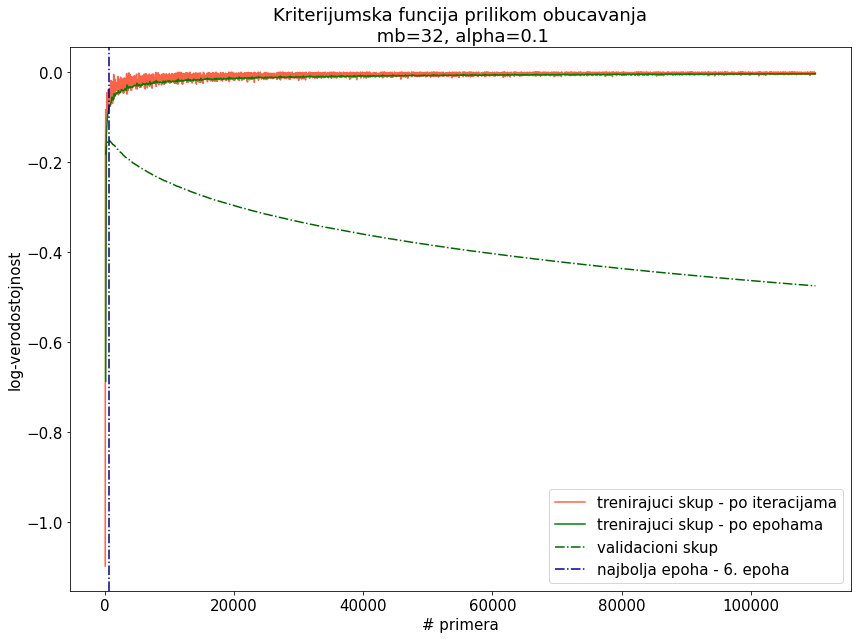

Najbolja vrednost funckije gubitka - log-verodostojnosti modela na validacionom skupu iznosi: -0.15144615215445564


In [19]:
# treniranje modela
best_theta, _, _ = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=opt_batch_size, lr=opt_learning_rate, expand=expand)

## Ilustracija treniranja Softmax modela sa optimalnom stopom učenja, ali sa premalom/prevelikom veličinom mini-šarže

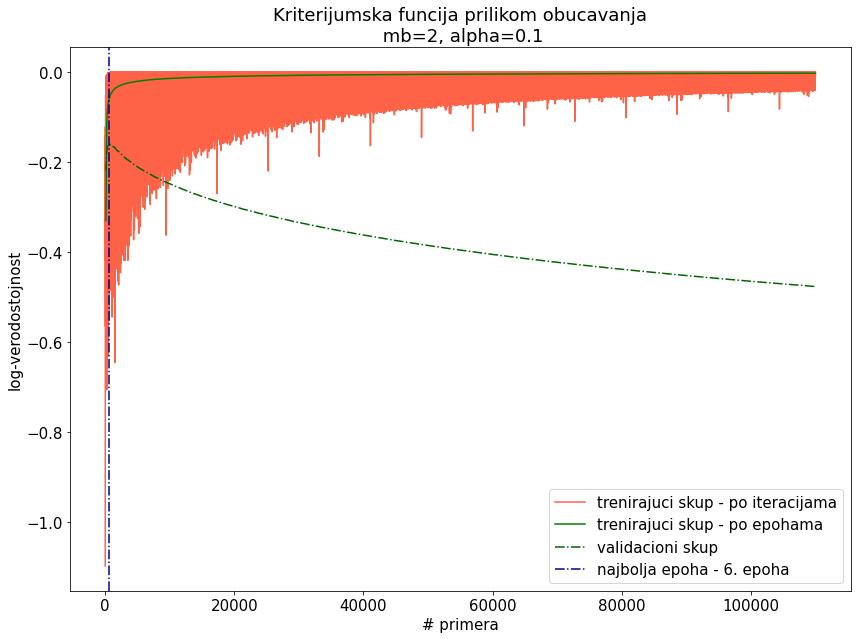

Najbolja vrednost funckije gubitka - log-verodostojnosti modela na validacionom skupu iznosi: -0.15975782530301832


In [20]:
# sa premalim batch_size-om
_, _, _ = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=2, lr=opt_learning_rate, expand=expand)

Na grafiku iznad je primetno slično ponašanje kao kod optimalnih parametara, osim činjenice da proces znatno duže traje i da na početku vrednosti loss funckije daleko odstupaju od optimalne.

Izvrseno je 33.267% procesa treniranja  

c:\users\jovan dmitrovic\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in double_scalars


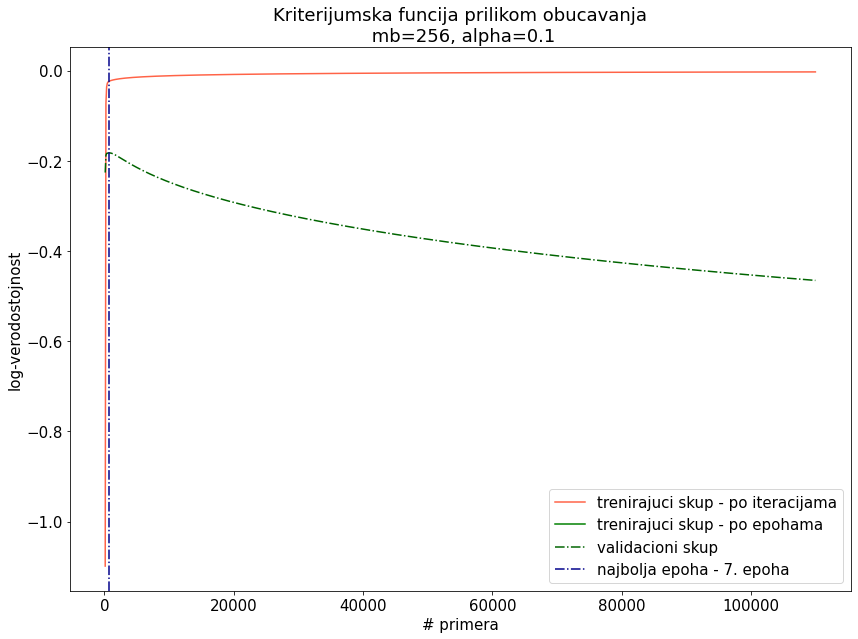

Najbolja vrednost funckije gubitka - log-verodostojnosti modela na validacionom skupu iznosi: -0.18238160374330714


In [21]:
# sa prevelikim batch_size-om
_, _, _ = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=256, lr=opt_learning_rate, expand=expand)

U ovom slučaju nema suma u trening krivoj i ona je ista po iteracijama i po epohama, jer je veličina šarže prevelika, pa jedna epoha zapravo uradi samo jednu šaržu. Primetno je da pronadjen optimum ima nešto lošiju vrednost od stvarnog.

## Ilustracija treniranja Softmax modela sa optimalnom veličinom mini-šarže, ali sa premalom/prevelikom stopom učenja

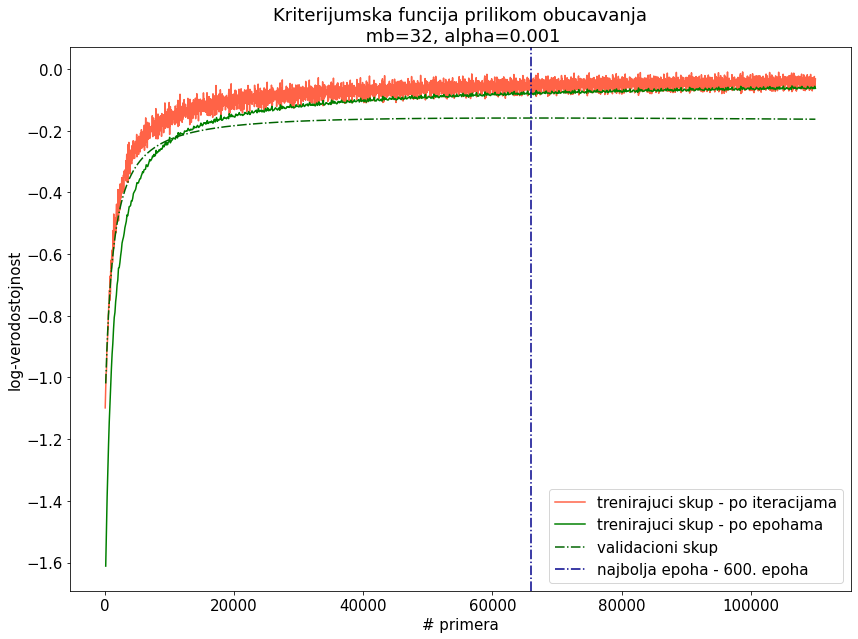

Najbolja vrednost funckije gubitka - log-verodostojnosti modela na validacionom skupu iznosi: -0.15869590268293193


In [22]:
# sa premalom stopom ucenja
_, _, _ = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=opt_batch_size, lr=0.001, expand=expand)

U ovom slučaju imamo optimalnu vrednost loss funkcije približno istu onoj stvarnoj optimalnoj. Primetan je pozitivan trend krivih na trening skupu, dakle još uvek nismo u nekom globalnom optimumu. Takodje, primetno je da je brzina konvergencije algoritma za ove hiper-parametre baš velika - 600 epoha, što je značajno veće od očekivane vrednosti za ovaj model.

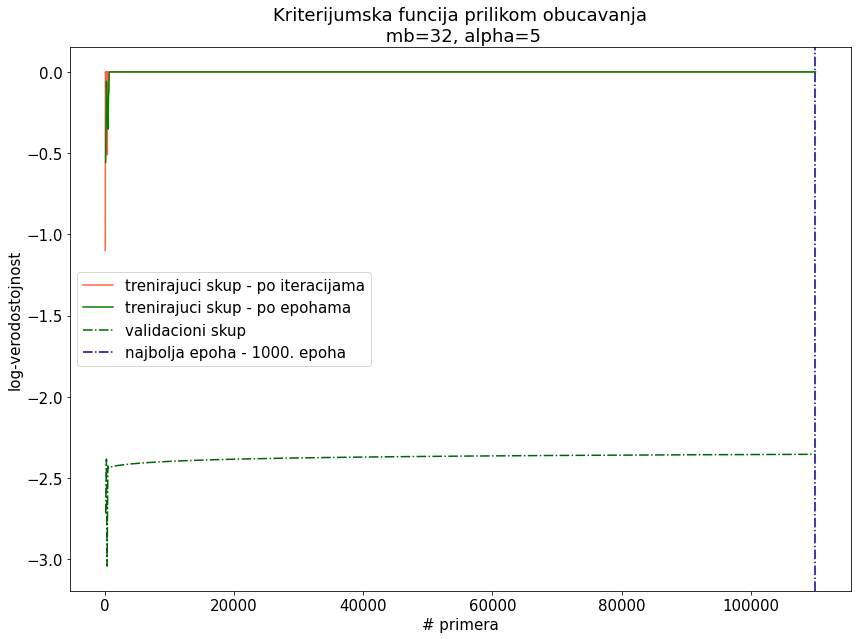

Najbolja vrednost funckije gubitka - log-verodostojnosti modela na validacionom skupu iznosi: -2.353408602987474


In [23]:
# sa prevelikom stopom ucenja
_, _, _ = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=opt_batch_size, lr=5, expand=expand)

I naravno, kao što je i očekivano, prevelika stopa učenja ne dovodi ni do kakvog optimuma.

# Implementacija funckija za prikaz metrika

In [24]:
def get_classification_report(y_true: np.ndarray, y_hat: np.ndarray, title: str) -> None:
    
    """
        Funkcija za racunanje svih metrika klasifikacije modela i prikaz matrice konfuzije.

        :params:
            - y_true: vektor tacnih klasa
            - y_hat: vetktor estimiranih klasa
            - title: naslov 
            
        :return:
            - None
    """
    
    # dohvatanje klasa
    classes, _ = get_classes_info(y, show_text=False)
    class_names = ['Klasa ' + str(cl) for cl in classes]
    
    # ispisivanje svih metrika
    print('\n-------------------------------------------------------------------------------------------------------------')
    print(f'                                            {title.upper()}')
    print('-------------------------------------------------------------------------------------------------------------')
    
    print('\nACCURACY: {:.2f}\n'.format(accuracy_score(y_true, y_hat)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_hat, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_hat, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_hat, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_hat, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_hat, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_hat, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_hat, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_hat, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_hat, average='weighted')))
    
    print('\n---------------- CLASSIFICATION REPORT ----------------\n')
    print(classification_report(y_true, y_hat, target_names=class_names))
    print('\n-------------------------------------------------------------------------------------------------------------')
    print('                                             MATRICA KONFUZIJE\n')
    
    # formiranje matrice konfuzije
    cm = confusion_matrix(y_true, y_hat, labels=classes)
    
    # formiranje pd.DataFrame-a za matricu konfuzije
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    
    # iscrtavanje matrice konfuzije
    plt.figure(figsize = (14, 10))
    sb.heatmap(df_cm, annot=True)
    plt.title(title)
    plt.xlabel('Estimirana klasa', )
    plt.ylabel('Originalna klasa')
    plt.show()

# Evaluacija Softmax modela

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------- PRIKAZ REZULTATA SOFTMAX KLASIFIKACIJE ----------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------
                                            OBUCAVAJUCI SKUP
-------------------------------------------------------------------------------------------------------------

ACCURACY: 0.99

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

----------------

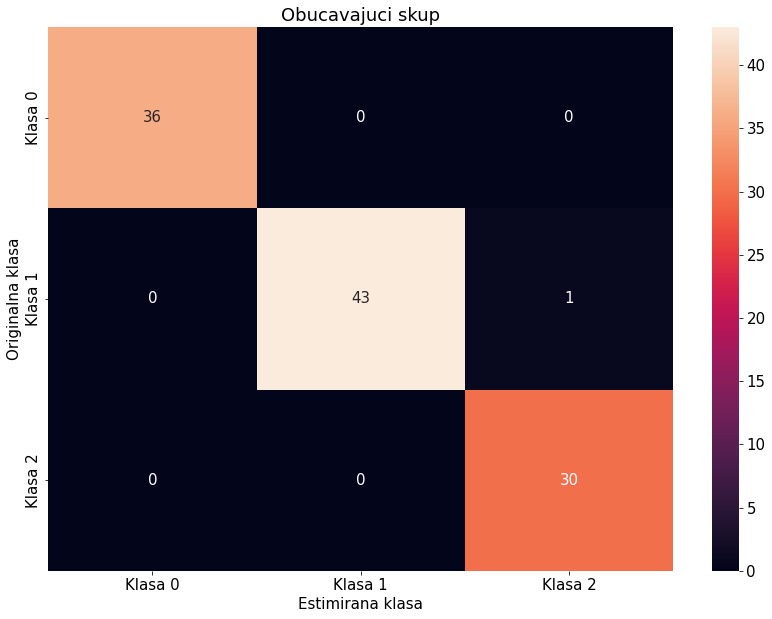


-------------------------------------------------------------------------------------------------------------
                                            VALIDACIONI SKUP
-------------------------------------------------------------------------------------------------------------

ACCURACY: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.93
Macro Recall: 0.94
Macro F1-score: 0.93

Weighted Precision: 0.94
Weighted Recall: 0.93
Weighted F1-score: 0.93

---------------- CLASSIFICATION REPORT ----------------

              precision    recall  f1-score   support

     Klasa 0       0.91      1.00      0.95        10
     Klasa 1       1.00      0.83      0.91        12
     Klasa 2       0.89      1.00      0.94         8

    accuracy                           0.93        30
   macro avg       0.93      0.94      0.93        30
weighted avg       0.94      0.93      0.93        30


----------------------------------------------------------------

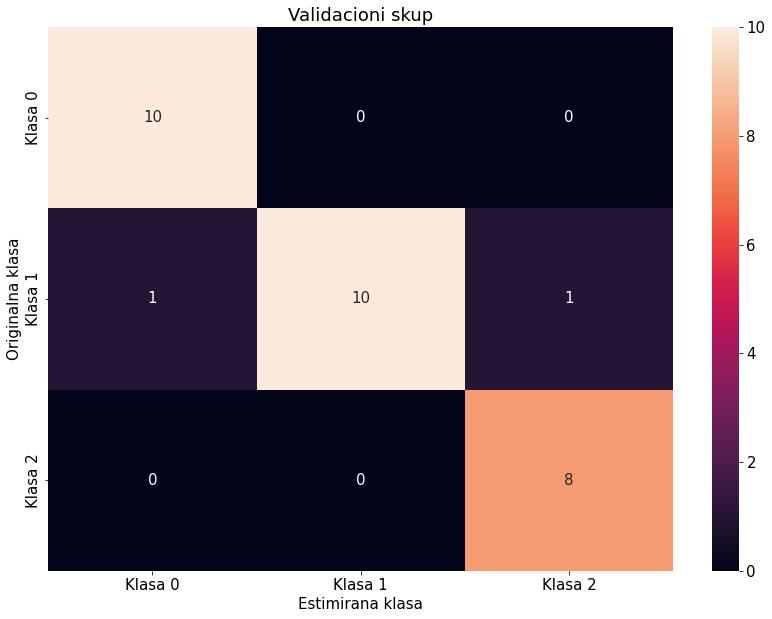


-------------------------------------------------------------------------------------------------------------
                                            TEST SKUP
-------------------------------------------------------------------------------------------------------------

ACCURACY: 0.86

Micro Precision: 0.86
Micro Recall: 0.86
Micro F1-score: 0.86

Macro Precision: 0.86
Macro Recall: 0.88
Macro F1-score: 0.87

Weighted Precision: 0.87
Weighted Recall: 0.86
Weighted F1-score: 0.86

---------------- CLASSIFICATION REPORT ----------------

              precision    recall  f1-score   support

     Klasa 0       0.86      1.00      0.92        12
     Klasa 1       0.92      0.73      0.81        15
     Klasa 2       0.82      0.90      0.86        10

    accuracy                           0.86        37
   macro avg       0.86      0.88      0.87        37
weighted avg       0.87      0.86      0.86        37


-----------------------------------------------------------------------

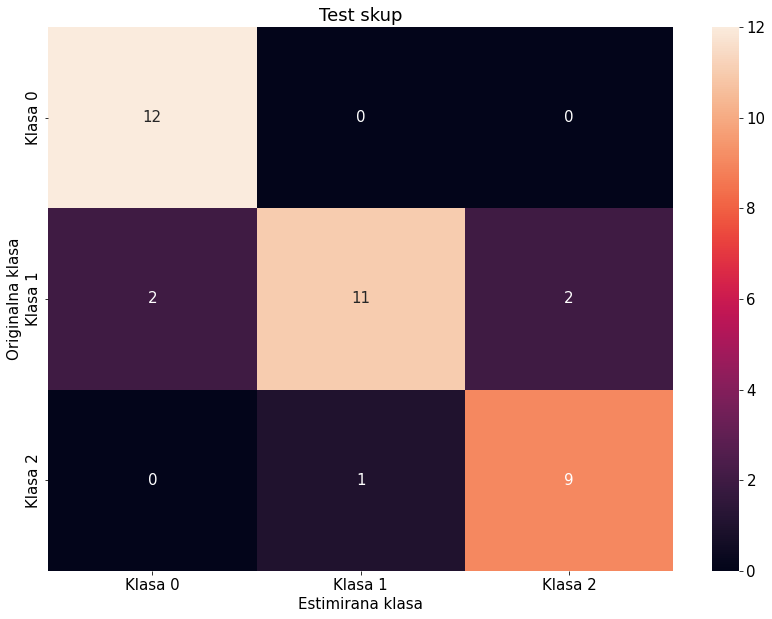

In [25]:
print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('--------------------------------------------------------- PRIKAZ REZULTATA SOFTMAX KLASIFIKACIJE ----------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------\n')

for x, y, dataset_name in \
    zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['Obucavajuci skup', 'Validacioni skup', 'Test skup']):
        
    # predikcija modela
    y_hat = sotfmax_predict(x, best_theta, expand)
    
    # matrica konfuzije
    get_classification_report(y, y_hat, title=dataset_name)

Vrednosti tačnosti (accuracy) Softmax modela dobijene za ovaj zadatak su poprilično zadovoljavajuće. Jedino tačnost na test skupu jeste manja od 90%, ali ne znatno. Za krivca ovih vrednosti tačnosti modela se može proglasiti veličina skupa podataka, pa i sama podela podataka na skupove.

In [26]:
del X_train, y_train, X_val, y_val, X_test, y_test, best_theta

# ------------------------------ Gauss-ovska diskriminantna analiza ------------------------------

# Teorijski osvrt

Gauss-ovska diskriminantna analiza jeste jedan od predstavnika generativnih algoritama iz oblasti mašinskog učenja. Ovim postupkom želimo da, za izlaznu kategoričku
promenljivu - y, odredimo uslovnu verovatnoću pripadanja podataka x nekoj od klasa iz y. U pomoć priskače Bayes-ova formula: $$p(y|x) = p(x|y)p(y)/p(x) $$, i pretpostavka da uslovna verovatnoća $p(x|y)$ ima Gauss-ovu raspodelu sa vektorima srednje vrednosti i kovarijacionima matricama koje treba odrediti - to su parametri ovog modela.

Učenje parametara ovog modela vrši se maksimizacijom verodostojnošću. Medjutim, kako ovaj problem uvodi normalnu raspodelu, moguće je iskoristiti neke njene prednosti, zbog toga se optimalne vrednosti parametara (vektor srednje vrednosti i kovarijaciona matrica) po klasama dobijaju kao srednja vrednost svih vrednosti prediktora iz X-a, a kovarijaciona matrica kao proizvod centriranih vrednosti.

# Implementacija funkcija za GDA model

In [27]:
def fit_model(X_train: np.ndarray, y_train: np.ndarray) -> tuple:
    
    """
        Funkcija za fitovanje GDA modela nad prosledjenim skupom podataka.

        :params:
            - X_train: matrica primera svih prediktora -> dimenzije m x n
            - y_train: vetkor klasa -> dimenzije m x 1
            
        :return:
            - phi: vektor apriornih verovatnoca pojave klase -> dimenzije k x 1
            - mu: matrica koja sadrzi vektore sr. vrednosti svake klase -> dimenzije k x n
            - sig: 3D niz koji sadzi kovarijacione matrice svih klasa -> dimenzije k x n x n
    """
    
    # dohvatanje broja primera 
    m = X_train.shape[0]
    
    # dohvatanje broja prediktora
    n = X_train.shape[1]
    
    # dohvatanje informacija o klasa 
    classes, classes_dict = get_classes_info(y_train, show_text=False)
    
    # dohvatanje broja klasa
    k=len(classes)
    
    # vektor apriornih verovatnoca 
    phi = np.array([classes_dict[i]/m for i in range(k)]).reshape((k,))
    
    # matrica srednjih vrednosti
    mu = np.zeros((k,n), dtype='float32')
    
    # 3d niz kovarijacionih matrica
    sig = np.zeros((k,n,n), dtype='float32')
    
    # odredjivanje 
    for i in range(k):
        # selektovanje 
        X = X_train[y_train==i]
        
        # odredjivanje vektora srednje vrednosti
        mu_vec = np.mean(X, axis=0)
        mu[i,:] = mu_vec
        
        # odredjivanje kovarijacione matrice
        sig[i,:,:] = (X.T - mu_vec.reshape((-1,1)))@(X-mu_vec.reshape((1,-1)))/classes_dict[i]
        
    params = (phi, mu, sig)
    
    return params

In [28]:
def gda_predict(X: np.ndarray, phi: np.ndarray, mu: np.ndarray, sig: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za estimaciju izlaznih klasa prosledjenih podataka.

        :params:
            - X: matrica primera svih prediktora -> dimenzije m x n
            - phi: vektor apriornih verovatnoca pojave klase -> dimenzije k x 1
            - mu: matrica koja sadrzi vektore sr. vrednosti svake klase -> dimenzije k x n
            - sig: 3D niz koji sadzi kovarijacione matrice svih klasa -> dimenzije k x n x n
            
        :return:
            - y_hat: predikcije izlazne klase -> dimenzije m x 1
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # dohvatanje broja prediktora
    n = X.shape[1]
    
    # dohvatanje broja klasa
    k = phi.size
    
    # matrica uslovnih verovatnoca za X ako je fiksirano y -> dimenzije m x k
    prob_x = np.zeros((m,k), dtype='float32')
    
    # promenljiva za racunanje totalne verovatnoce za X
    prob_x_total = np.zeros((m,), dtype='float32')
    
    # racunanje uslovnih verovatnoca za X, ako je fiksirano y ~N(mu, sig)
    for i in range(k):
        
        phi_ = phi[i]
        mu_ = mu[i,:].reshape((1,-1))
        sig_ = sig[i,:,:]
        
        exp_ = -0.5*((X-mu_) @ np.linalg.inv(sig_) @ (X-mu_).T)
        
        # racunanje uslovne verovatnoce
        prob_x[:,i] = (1/(np.sqrt(2*np.pi*np.linalg.det(sig_)))) * np.exp(np.diagonal(exp_))
        
        # dodavanje na totalnu verovatnocu
        prob_x_total += prob_x[:,i]*phi_
    
    # matrica uslovnih verovatnoca za y ako je fiksirano X -> dimenzije m x k
    prob_y = np.zeros((m,k), dtype='float32')
    
    # racunanje uslovnih verovatnoca za y, ako je fiksirano X, prema Bayes-ovoj formuli
    for i in range(k):
        
        phi_ = phi[i]
        
        prob_y[:,i] = prob_x[:,i]*phi_ / prob_x_total
    
    # finalno racunanje klase
    y_hat = np.argmax(prob_y, axis=1)
    
    return y_hat

# Fitovanje GDA modela

In [29]:
# ucitavanje podataka
X, y = read_data()

# podela podataka na trening i test skup
X_train, y_train, X_test, y_test = train_test_data_split(X, y)

# fitovanje GDA modela
params = fit_model(X_train, y_train)

# Evaluacija GDA modela

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------- PRIKAZ REZULTATA GDA KLASIFIKACIJE ------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------
                                            OBUCAVAJUCI SKUP
-------------------------------------------------------------------------------------------------------------

ACCURACY: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.98
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

----------------

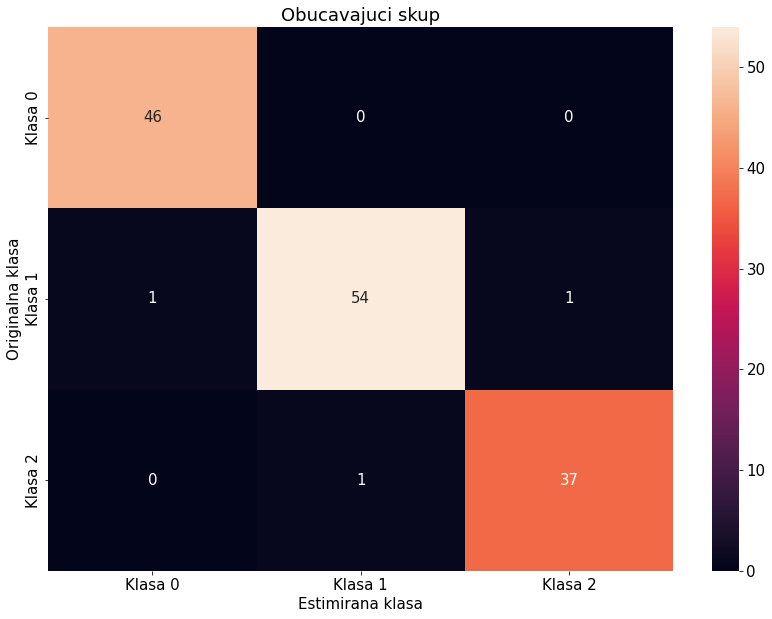


-------------------------------------------------------------------------------------------------------------
                                            TEST SKUP
-------------------------------------------------------------------------------------------------------------

ACCURACY: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.93
Macro Recall: 0.93
Macro F1-score: 0.93

Weighted Precision: 0.94
Weighted Recall: 0.92
Weighted F1-score: 0.92

---------------- CLASSIFICATION REPORT ----------------

              precision    recall  f1-score   support

     Klasa 0       0.80      1.00      0.89        12
     Klasa 1       1.00      0.80      0.89        15
     Klasa 2       1.00      1.00      1.00        10

    accuracy                           0.92        37
   macro avg       0.93      0.93      0.93        37
weighted avg       0.94      0.92      0.92        37


-----------------------------------------------------------------------

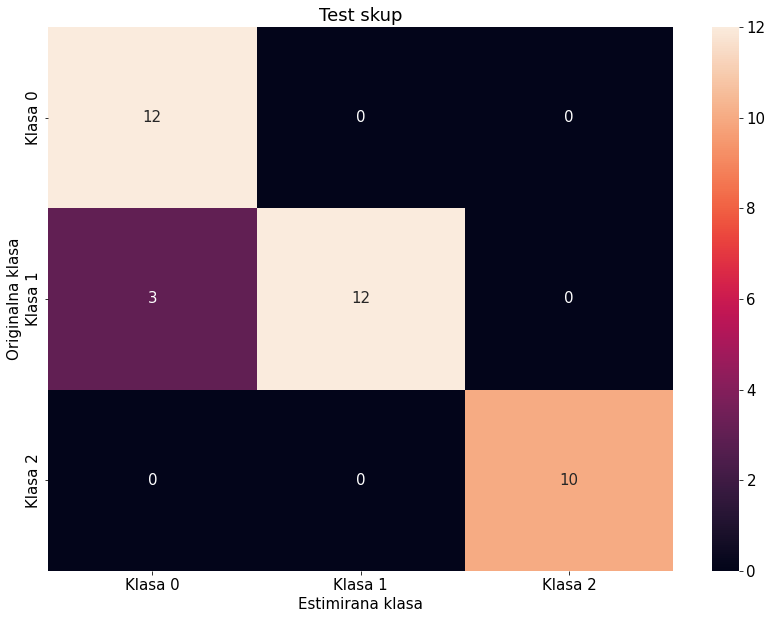

In [30]:
print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('----------------------------------------------------------- PRIKAZ REZULTATA GDA KLASIFIKACIJE ------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------\n')



for x, y, dataset_name in \
    zip([X_train, X_test], [y_train, y_test], ['Obucavajuci skup', 'Test skup']):
        
    # predikcija modela
    y_hat = gda_predict(x, *params)
    
    # matrica konfuzije
    get_classification_report(y, y_hat, title=dataset_name)

U ovom primeru nema potrebe za podelom celokupnog skupa podataka na trening, validacioni i test skup, vec je dovoljno samo na trening i test skup. Na trening skupu su odredjeni parametri modela i dobijena tačnost je vrlo zadovoljavajuća. Tačnost na test skupu je takodje vrlo dobra i znatno veća od one kod Softmax modela, čak 6% (što nije generalno veliko, ali za test skup je vrlo značajno.) Ovo poboljšanje moguće pripisati i većem trening skupu, kao i zapravo samim podacima, jer ako su oni genersani kao nekakva normalna raspodela (nekako ponderisana), veća je šansa da ovaj algoritam bolje detektuje klastere, nego li Softmax model.